# Packages

In [1]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from wordcloud import WordCloud
from collections import Counter
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import text

# Scraping the data

In [2]:
tw_scraper = sntwitter.TwitterProfileScraper('accenture')

In [3]:
#help(sntwitter)

In [4]:
#this code is to see the first (newest) tweet
for tweet in tw_scraper.get_items():
    break

In [5]:
tweet

Tweet(url='https://twitter.com/Accenture/status/1587081352167493634', date=datetime.datetime(2022, 10, 31, 13, 57, 35, tzinfo=datetime.timezone.utc), rawContent='We can use #AI to understand how our planet is changing—and most importantly, how we can respond. Watch the full episode. https://t.co/4V6Nup6mze @WIRED https://t.co/Scfk14fUXn', renderedContent='We can use #AI to understand how our planet is changing—and most importantly, how we can respond. Watch the full episode. accntu.re/3Md9swP @WIRED https://t.co/Scfk14fUXn', id=1587081352167493634, user=User(username='Accenture', id=10194682, displayname='Accenture', rawDescription='Together, we deliver on the promise of technology and human ingenuity. Let there be change.', renderedDescription='Together, we deliver on the promise of technology and human ingenuity. Let there be change.', descriptionLinks=None, verified=False, created=datetime.datetime(2007, 11, 12, 21, 34, tzinfo=datetime.timezone.utc), followersCount=549000, friendsCo

In [6]:
tw_scraper = sntwitter.TwitterProfileScraper('accenture')
tweets = []

for tweet in tw_scraper.get_items():
    tw_data = [
        tweet.date, 
        tweet.rawContent, 
        tweet.replyCount, 
        tweet.retweetCount, 
        tweet.likeCount, 
        tweet.quoteCount, 
        tweet.hashtags
    ]
    tweets.append(tw_data)

In [7]:
tweet_df = pd.DataFrame(tweets, columns = ["timestamp", "content", "reply_count", "retweet_count", "like_count", "quote_count", "hashtags"])

In [8]:
tweet_df

,timestamp,content,reply_count,retweet_count,like_count,quote_count,hashtags
0,2022-10-31 13:57:35+00:00,We can use #AI to understand how our planet is...,50,43,118,9,[AI]
1,2022-10-28 19:48:18+00:00,Web3 is laying the foundation for the #metaver...,20,29,71,5,"[metaverse, RadicallyHuman]"
2,2022-10-27 14:12:00+00:00,"What does captured carbon, affordable housing ...",4,10,48,0,None
3,2022-10-26 13:00:13+00:00,"A digital world where you can create, connect,...",10,18,50,0,[BuiltForChange]
4,2022-10-25 14:08:01+00:00,3 sets of machines are going to dramatically r...,1,7,36,1,[TechVision]
...,...,...,...,...,...,...,...
3180,2018-05-04 17:12:34+00:00,@jggnyc Well played! And no. https://t.co/twkv...,0,1,2,0,None
3181,2018-05-04 16:14:11+00:00,"Don't worry, these are Jedi in disguise. #MayT...",5,54,188,10,"[MayThe4thBeWithYou, StarWarsDay]"
3182,2018-05-04 07:30:09+00:00,“There probably has not been a better time in ...,2,16,38,0,None
3183,2018-05-03 22:00:07+00:00,What are the 5 key trends that help enterprise...,0,9,15,0,None


# Data transformations

1. Transforming timestamp column to date and time columns

In [9]:
tweet_df['timestamp'] = pd.to_datetime(tweet_df['timestamp'])
tweet_df['timestamp'] = tweet_df['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))

In [10]:
tweet_df['date'] = pd.to_datetime(tweet_df['timestamp']).dt.date
tweet_df['date'] = pd.to_datetime(tweet_df['date'])
tweet_df['hour'] = pd.to_datetime(tweet_df['timestamp']).dt.hour

2. Deleting 'timestamp' column

In [11]:
tweet_df = tweet_df.drop(['timestamp'], axis = 1)

3. Cleaning 'hashtags' column by changing None values of None type to empty lists and counting them

In [12]:
tweet_df['hashtags'] = tweet_df['hashtags'].apply(lambda x: [] if x is None else x)
tweet_df['hashtag_count'] = tweet_df['hashtags'].apply(len)

4. Extracting emojis from the content and counting them

In [13]:
def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

In [14]:
tweet_df['emojis'] = tweet_df['content'].apply(extract_emojis)

In [15]:
tweet_df['emoji_count'] = tweet_df['emojis'].apply(len)

5. Flipping the table from the oldest post to newest and refresh index

In [16]:
tweet_df = tweet_df.sort_values('date')
tweet_df = tweet_df.reset_index(drop = True)
tweet_df = tweet_df.rename_axis('id')

# General statistics 

In [17]:
general_stats = tweet_df.describe()
general_stats_rounded = general_stats.round(2)
general_stats_rounded

,reply_count,retweet_count,like_count,quote_count,hour,hashtag_count,emoji_count
count,3185.00,3185.00,3185.00,3185.00,3185.00,3185.00,3185.00
mean,1.22,32.90,37.11,0.95,15.17,0.90,0.55
std,6.85,1160.52,174.80,4.23,4.03,0.82,1.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,2.00,2.00,0.00,13.00,0.00,0.00
50%,0.00,6.00,16.00,0.00,15.00,1.00,0.00
75%,1.00,10.00,25.00,1.00,18.00,1.00,0.00
max,283.00,65454.00,3754.00,178.00,23.00,6.00,49.00


# Line chart to visualise daily tweet count from 2018-2022

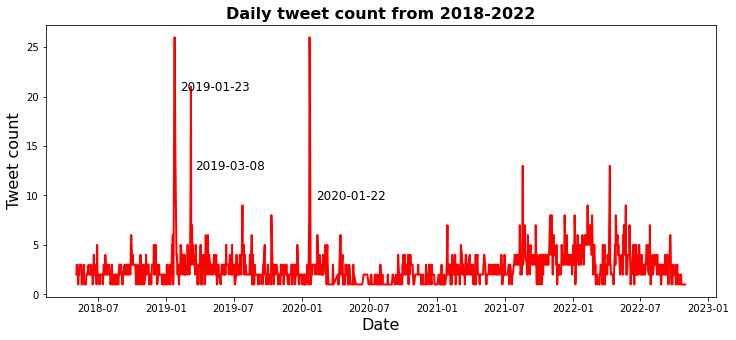

In [18]:
# convert date column to pandas datetime and group by date and count tweets
tweet_df['date'] = pd.to_datetime(tweet_df['date']).dt.date
daily_tweet_count = tweet_df.groupby('date')['content'].count()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(daily_tweet_count.index, daily_tweet_count.values, linewidth=2, color='red')
ax.text(17935, 20.6, "2019-01-23", fontsize = 12)
ax.text(17975, 12.6, "2019-03-08", fontsize = 12)
ax.text(18300, 9.6, "2020-01-22", fontsize = 12)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Tweet count', fontsize=16)
ax.set_title('Daily tweet count from 2018-2022', fontsize=16, fontweight='bold')
plt.savefig('plot_1.png', format='png')
plt.show()

# Tweets during various times of day

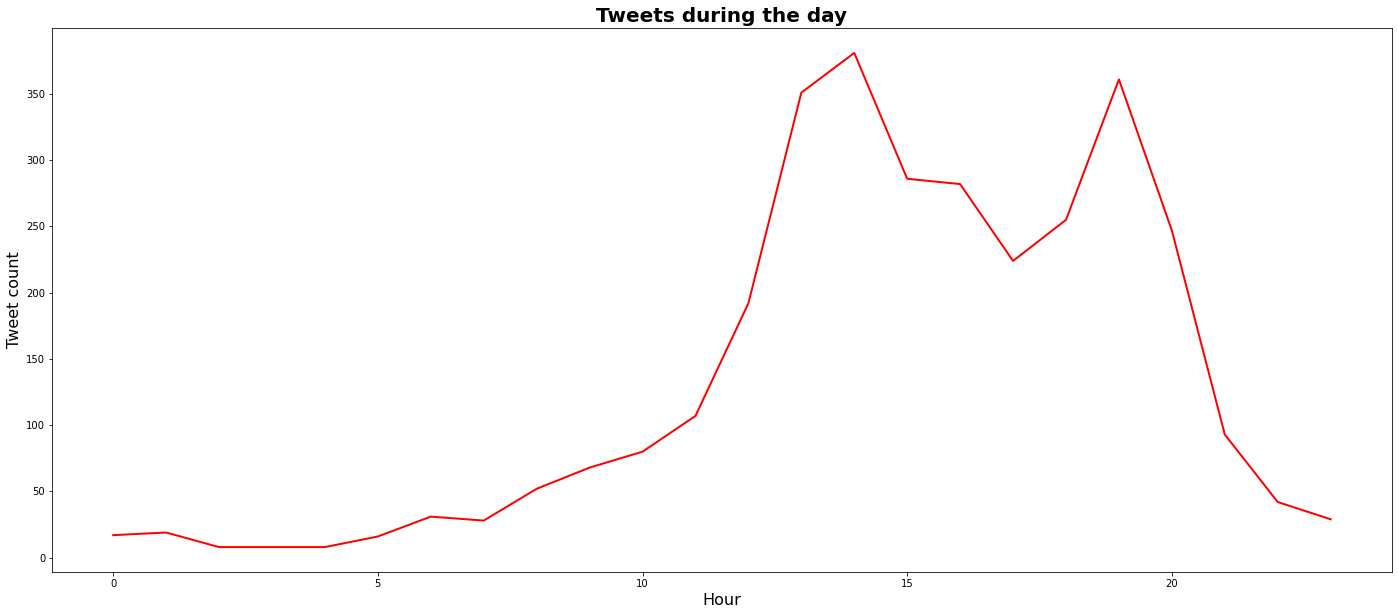

In [19]:
post_count = tweet_df.groupby('hour')['content'].count()

fig, ax = plt.subplots(figsize=(24, 10))
ax.plot(post_count.index, post_count.values, linewidth=2, color='red')
ax.set_xlabel('Hour', fontsize=16)
ax.set_ylabel('Tweet count', fontsize=16)
ax.set_title('Tweets during the day', fontsize=20, fontweight='bold')
plt.show()

# Average tweets per day

In [20]:
tweet_df['date'] = pd.to_datetime(tweet_df['date']).dt.date
daily_tweet_count = tweet_df.groupby('date')['content'].count().mean()
rounded_average_tweets = round(daily_tweet_count, 2) 

print("Average number of tweets per day:", rounded_average_tweets)

Average number of tweets per day: 2.78


# Filtered largest tweet count and most popular hashtags in these tweets

In [21]:
# Sort the DataFrame by tweet count in descending order
sorted_df = tweet_df.groupby('date').size().reset_index(name='tweet_count').sort_values(by='tweet_count', ascending=False)

# Extract the top 10 dates with the largest tweet count
top_dates = sorted_df.head(10)

# Make dataframe
result_df = pd.DataFrame(columns=['Date', 'Tweet Count', 'Popular Hashtags'])
for date in top_dates['date']:
    new_df = tweet_df[tweet_df['date'] == date]
    hashtags = new_df['hashtags'].str.join(' ')
    hashtags_freq = pd.Series(hashtags.str.split().sum()).value_counts()
    popular_hashtags = hashtags_freq.head(3).index.tolist()
    tweet_count = top_dates[top_dates['date'] == date]['tweet_count'].iloc[0]
    temp_df = pd.DataFrame({'Date': [date], 'Tweet Count': [tweet_count], 'Popular Hashtags': [popular_hashtags]})
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

result_df

,Date,Tweet Count,Popular Hashtags
0,2020-01-22,26,"[WEF20, IntoTheNew, AccentureAtDavos]"
1,2019-01-23,26,"[WEF19, InternetOfTrust, ResponsibleAI]"
2,2019-03-08,21,"[GettingToEqual, IWD2019, 5G]"
3,2019-01-22,21,"[WEF19, FutureWorkforce, ResponsibleAI]"
4,2020-01-23,20,"[WEF20, sustainability, UnitingBusiness]"
5,2019-01-24,19,"[WEF19, ResponsibleAI, InternetOfTrust]"
6,2019-01-25,14,"[WEF19, InternetOfTrust, FutureWorkforce]"
7,2021-08-19,13,"[PrideAtAccenture, WorldPride, BusinessFutures..."
8,2022-04-11,13,"[GPTW, Metaverse, TechVision]"
9,2019-03-07,11,"[IWD2019, GettingToEqual, cloud]"


# Percentage of each type of engagement (reply count, retweets count, likes count and quote count)

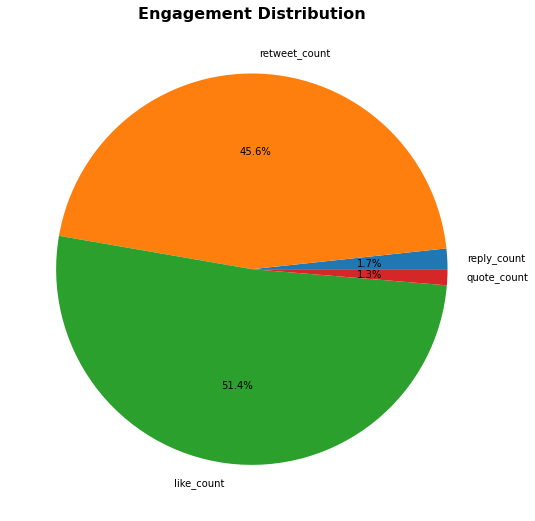

In [22]:
# Calculate the total engagement (sum of reply, retweet, like, and quote counts) and calculate the percentage of each type of engagement
total_engagement = tweet_df[['reply_count', 'retweet_count', 'like_count', 'quote_count']].sum().sum()
engagement_percentages = tweet_df[['reply_count', 'retweet_count', 'like_count', 'quote_count']].sum() / total_engagement
fig, ax = plt.subplots(figsize=(20, 9))
ax.pie(engagement_percentages.values, labels=engagement_percentages.index, autopct='%1.1f%%')
ax.set_title('Engagement Distribution', fontsize=16, fontweight='bold')
plt.savefig('plot_2.png', format='png')
plt.show()

# Percentage of total number of retweets and replies

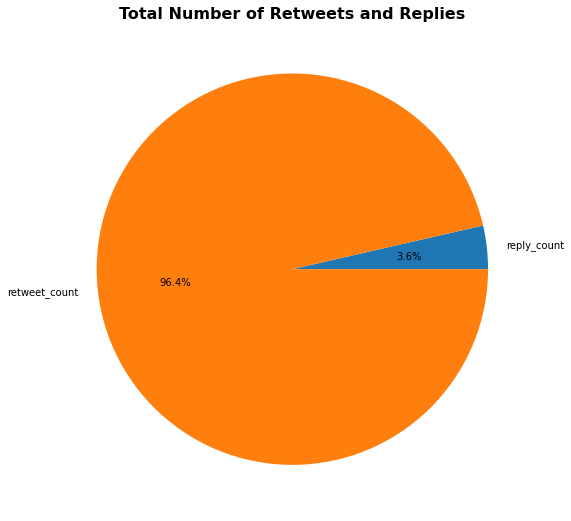

In [23]:
fig, ax = plt.subplots(figsize=(10, 9))
total_engagement = tweet_df[['reply_count', 'retweet_count']].sum().sum()
engagement_percentages = tweet_df[['reply_count', 'retweet_count']].sum() / total_engagement
ax.pie(engagement_percentages.values, labels=engagement_percentages.index, autopct='%1.1f%%')
ax.set_title('Total Number of Retweets and Replies', fontsize=16, fontweight='bold')
plt.savefig('plot_3.png', format='png')
plt.show()

# Cumulative Engagement over Time

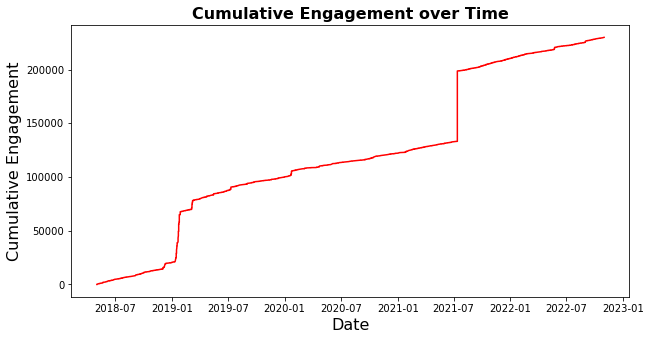

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
tweet_df['cumulative_engagement'] = tweet_df[['reply_count', 'retweet_count', 'like_count', 'quote_count']].sum(axis=1).cumsum()
ax.plot(tweet_df['date'], tweet_df['cumulative_engagement'], color='red')
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Cumulative Engagement', fontsize=16)
ax.set_title('Cumulative Engagement over Time', fontsize=16, fontweight='bold')
plt.savefig('plot_4.png', format='png')
plt.show()

# Distribution of Likes (with up to 100 likes)

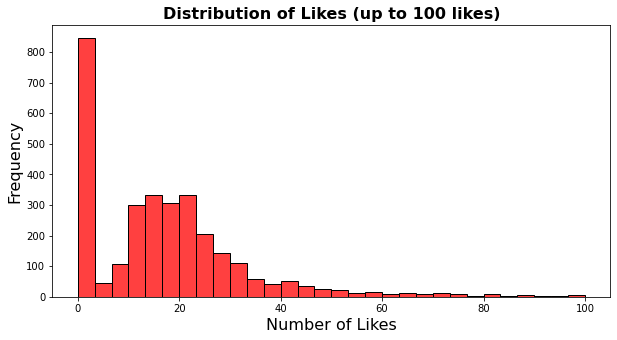

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(tweet_df[tweet_df['like_count'] <= 100]['like_count'], bins=30, color='red')
ax.set_xlabel('Number of Likes', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Distribution of Likes (up to 100 likes)', fontsize=16, fontweight='bold')
plt.savefig('plot_5.png', format='png')
plt.show()
# Most frequently there are tweets with number of likes between 10 and 30

# Average number of likes per tweet and median of likes

In [26]:
mean_likes = statistics.mean(tweet_df['like_count'])
rounded_average_likes = round(mean_likes, 2) 
print("Average number of likes per tweet:", rounded_average_likes)


median_likes = statistics.median(tweet_df['like_count'])
print("Median likes:", median_likes)

Average number of likes per tweet: 37.11
Median likes: 16


# Distribution of Retweets (with retweet count < 20)

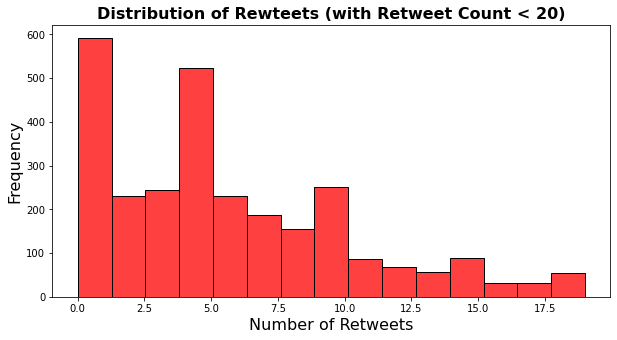

In [27]:
# Create a dataframe with quote_count less than 20
filtered_df = tweet_df[tweet_df['retweet_count'] < 20]

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=filtered_df, x='retweet_count', bins=15, color='red')
ax.set_xlabel('Number of Retweets', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Distribution of Rewteets (with Retweet Count < 20)', fontsize=16, fontweight='bold')
plt.savefig('plot_6.png', format='png')
plt.show()
# Most frequently there are tweets with number of retweets below 10 

# Average number of retweets per tweet and median of retweets

In [28]:
mean_retweets = statistics.mean(tweet_df['retweet_count'])
rounded_average_retweets = round(mean_retweets, 2) 
print("Average number of retweets per tweet:", rounded_average_retweets)

median_retweets = statistics.median(tweet_df['retweet_count'])
print("Median retweets:", median_retweets)

Average number of retweets per tweet: 32.9
Median retweets: 6


# Bar chart of the top 15 hashtags

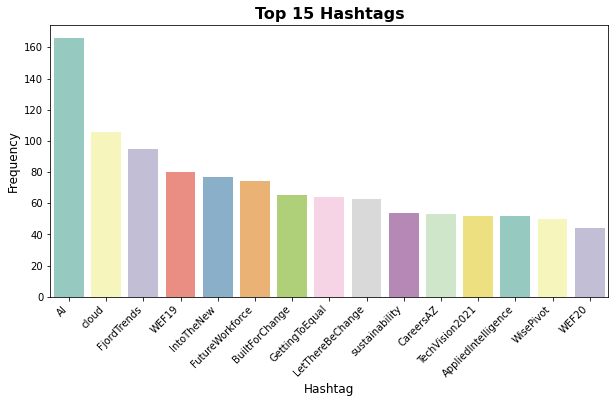

In [29]:
# Drop rows with null values in the "hashtags" column and create a list of all hashtags
hashtags = [tag for tags in tweet_df['hashtags'] for tag in tags]

# Count the frequency of each hashtag and select the top 10 hashtags
hashtag_counts = pd.Series(hashtags).value_counts()
top_hashtags = hashtag_counts.head(15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=top_hashtags.index, y=top_hashtags.values, palette='Set3')
ax.set_title('Top 15 Hashtags', fontsize=16, fontweight='bold')
ax.set_xlabel('Hashtag', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.savefig('plot_7.png', format='png')
plt.show()

# Wordcloud with most popular hashtags in tweets

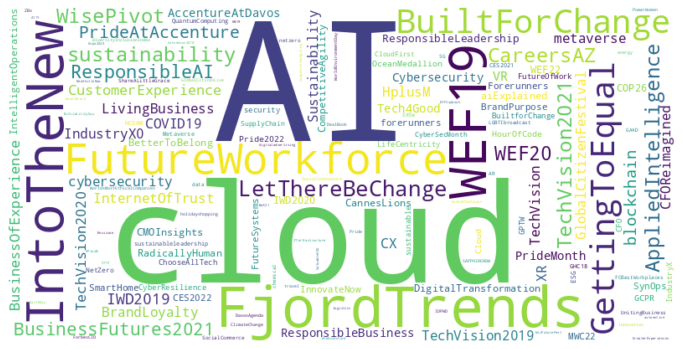

In [30]:
# Combine all the hashtags into a single string and count the frequency of each hashtag
hashtags = tweet_df['hashtags'].str.join(' ')
hashtags_freq = Counter(hashtags.str.split().sum())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hashtags_freq)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('plot_8.png', format='png')
plt.show()

# Boxplot of Like Count and Retweet Count

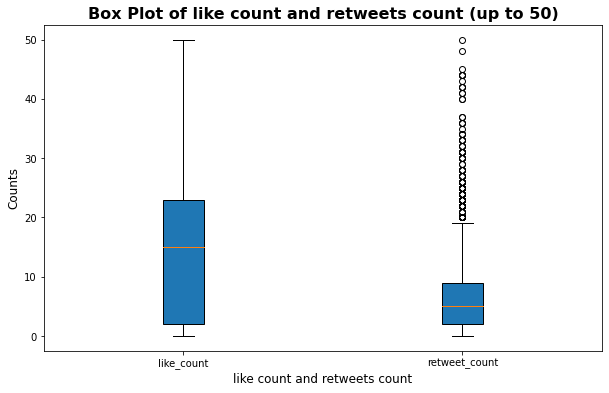

In [31]:
filtered_df = tweet_df[(tweet_df['retweet_count'] <= 50) & (tweet_df['like_count'] <= 50)]
columns = ['like_count', 'retweet_count']

plt.figure(figsize=(10, 6))
plt.boxplot(filtered_df[columns].values, patch_artist=True)
plt.xlabel('like count and retweets count',fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Box Plot of like count and retweets count (up to 50)', fontsize=16, fontweight='bold')
plt.xticks(range(1, len(columns) + 1), columns)
plt.show()

# Scatter chart to visualise correlation between retweet count and like count

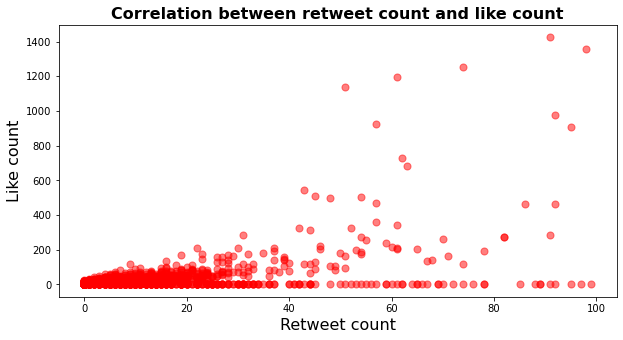

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
graf = tweet_df['retweet_count'] <= 100
ax.scatter(tweet_df[graf]['retweet_count'], tweet_df[graf]['like_count'], s=50, alpha=0.5, color='red')
ax.set_xlabel('Retweet count', fontsize=16)
ax.set_ylabel('Like count', fontsize=16)
ax.set_title('Correlation between retweet count and like count', fontsize=16, fontweight='bold')
plt.savefig('plot_10.png', format='png')
plt.show()

# Scatter chart to visualise correlation between reply count and retweet count

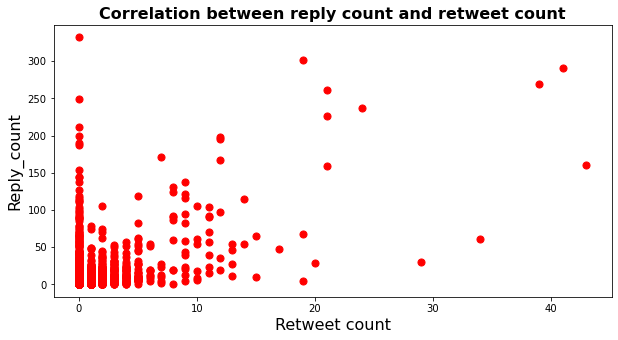

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
filtered_tweet_df = tweet_df[(tweet_df['reply_count'] < 50) & (tweet_df['retweet_count'] < 400)]
ax.scatter(filtered_tweet_df['reply_count'], filtered_tweet_df['retweet_count'], s=50, color='red')
ax.set_xlabel('Retweet count', fontsize=16)
ax.set_ylabel('Reply_count', fontsize=16)
ax.set_title('Correlation between reply count and retweet count', fontsize=16, fontweight='bold')
plt.savefig('plot_11.png', format='png')
plt.show()

# Boxplot of Like count by Hashtag count

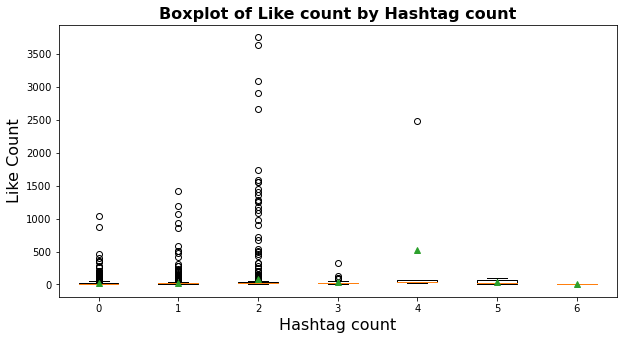

In [34]:
grouped = tweet_df.groupby('hashtag_count')['like_count']

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot([grouped.get_group(key) for key in grouped.groups.keys()], showmeans=True)
plt.xticks(range(1, len(grouped.groups.keys()) + 1), grouped.groups.keys())
ax.set_xlabel('Hashtag count', fontsize = 16)
ax.set_ylabel('Like Count', fontsize = 16)
ax.set_title('Boxplot of Like count by Hashtag count', fontsize=16, fontweight='bold')
plt.show()

# Correlation between Emoji count and Like count

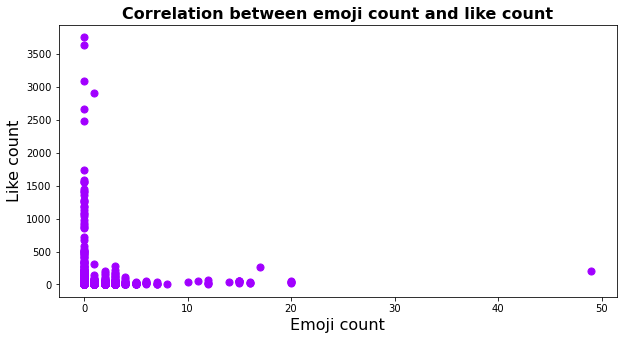

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tweet_df['emoji_count'], tweet_df['like_count'], s=50, color='#A100FF')
ax.set_xlabel('Emoji count', fontsize=16)
ax.set_ylabel('Like count', fontsize=16)
ax.set_title('Correlation between emoji count and like count', fontsize=16, fontweight='bold')
plt.show()

# Correlation Matrix

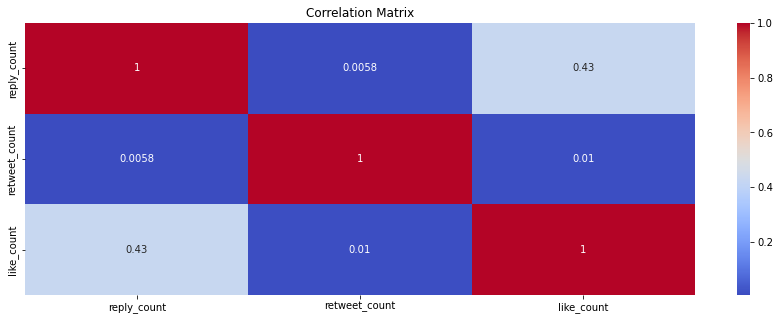

In [36]:
corr_matrix = tweet_df[['reply_count', 'retweet_count', 'like_count']].corr()
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
ax.set_title('Correlation Matrix')
plt.savefig('plot_12.png', format='png')
plt.show()

# Wordcloud from emojis :)

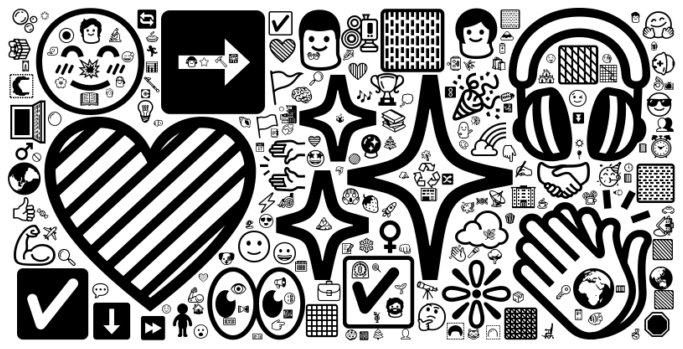

In [37]:
# Combine all the hashtags into a single string count the frequency of each emojie
all_emojis = tweet_df['emojis'].str.join(' ')
emojis_freq = Counter(all_emojis.str.split().sum())

# Generate a word cloud from the hashtag frequency dictionary usind NotoEmoji library
wordcloud = WordCloud(font_path = 'NotoEmoji-Bold.ttf', width=800, height=400, background_color='white', color_func=lambda *args, **kwargs: "black").generate_from_frequencies(emojis_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('plot_13.png', format='png')
plt.show()

# 5 most popular tweets by retweet count

In [38]:
popular_tweets = tweet_df[['date', 'content', 'retweet_count']].sort_values('retweet_count', ascending=False).head(5)
popular_tweets.to_csv('top_5_tweets.csv', index=False)
popular_tweets.to_excel('top_5_tweets.xlsx', index=False)
popular_tweets

,date,content,retweet_count
id,,,
2001,2021-07-13,"RT @GlblCtzn: #GlobalCitizenLive, featuring @e...",65454
1262,2020-01-23,RT @pauldaugh: Last year 73% of respondents sa...,1723
607,2019-03-07,RT @Reuters: ⚡️ “Women of the world” by @Reute...,1376
890,2019-07-11,Accenture is thrilled to announce Julie Sweet ...,428
1449,2020-06-04,RT @JulieSweet: There’s a time when words are ...,421


# 5 most popular tweets by reply count

In [39]:
popular_tweets = tweet_df[['date', 'content', 'reply_count']].sort_values('reply_count', ascending=False).head(5)
popular_tweets.to_csv('top_5_replies.csv', index=False)
popular_tweets.to_excel('top_5_replies.xlsx', index=False)
popular_tweets

,date,content,reply_count
id,,,
516,2019-01-25,Let's advance equality for LGBTI globally &amp...,283
466,2019-01-23,The Internet is strained. Digital trust is ero...,108
435,2019-01-21,#WEF19 Poll: Who should be primarily responsib...,98
600,2019-03-06,How do you define equality in a word? Our lead...,96
415,2019-01-17,"#WEF19 Poll: When used responsibly, what’s the...",84


# All data to csv and excel file

In [40]:
tweet_df['date'] = pd.to_datetime(tweet_df['date'])
tweet_df['date'] = tweet_df['date'].dt.tz_localize(None)
tweet_df.to_csv("tweet_data.csv", index=False)
tweet_df.to_excel("tweet_data.xlsx", index=False)

# Processing data for database

1. Adding hashtag table

In [56]:
hashtag_table = tweet_df[['hashtags']]

In [57]:
hashtag_table = hashtag_table.explode('hashtags')
hashtag_table = hashtag_table.fillna('')

hash_tags = hashtag_table['hashtags'].to_list()

hashtags = set(hash_tags)

In [58]:
hashtag_data = pd.DataFrame(hashtags)

In [59]:
hashtag_data = hashtag_data.rename(columns = {0 : 'hashtags'})
hashtag_data = hashtag_data.rename_axis('id')
hashtag_data = hashtag_data.reset_index()

In [78]:
engine = create_engine("mysql+pymysql://root:@localhost/sgt_finals")
hashtag_data.to_sql(name="hashtags",con=engine,if_exists="append",index=False)

481

2. Adding emoji table

In [62]:
emoji_table = tweet_df[['emojis']]
emoji_table = emoji_table.assign(emojis=emoji_table['emojis'].str.split(''))
emoji_table = emoji_table.explode('emojis')

emoji_list = emoji_table['emojis'].to_list()
emojis = set(emoji_list)

In [63]:
emoji_data = pd.DataFrame(emojis)

In [64]:
emoji_data = emoji_data.rename(columns = {0 : 'emojis'})
emoji_data = emoji_data.rename_axis('id')
emoji_data = emoji_data.reset_index()

In [79]:
engine = create_engine("mysql+pymysql://root:@localhost/sgt_finals")
emoji_data.to_sql(name="emojis",con=engine,if_exists="append",index=False)

248

3. Adding main table of content

In [66]:
main_table = tweet_df.copy()

In [67]:
main_table = main_table.reset_index()
main_table = main_table.assign(emojis=main_table['emojis'].str.split(''))
main_table = main_table.explode('emojis')
main_table = main_table.explode('hashtags')

In [68]:
merged_1 = pd.merge(main_table, hashtag_data, on = 'hashtags', how = 'left')
merged_2 = pd.merge(merged_1, emoji_data, on = 'emojis', how = 'left')

In [69]:
merged_2.drop_duplicates(inplace=True)
merged_2 = merged_2.reset_index()

In [70]:
merged_2 = merged_2.drop(['index', 'hashtags', 'emojis', 'cumulative_engagement'], axis = 1)

In [71]:
merged_2 = merged_2.fillna(0)
merged_2['id_y'] = merged_2['id_y'].astype('int')
merged_2 = merged_2.rename(columns = {'id' : 'id_emojis', 'id_y' : 'id_hashtags', 'id_x' : 'id'})

In [80]:
engine = create_engine("mysql+pymysql://root:@localhost/sgt_finals")
merged_2.to_sql(name="content",con=engine,if_exists="append",index=False)

5564

4. Adding keys to the tables

In [81]:
#primary key for hashtag table
engine = create_engine("mysql+pymysql://root:@localhost/sgt_finals")

with engine.connect() as con:
    statement = text('ALTER TABLE hashtags ADD PRIMARY KEY (id);')
    con.execute(statement)

In [82]:
#primary key for emoji table
engine = create_engine("mysql+pymysql://root:@localhost/sgt_finals")

with engine.connect() as con:
    statement = text('ALTER TABLE emojis ADD PRIMARY KEY (id);')
    con.execute(statement)

In [83]:
#primary key for content (main) table
engine = create_engine("mysql+pymysql://root:@localhost/sgt_finals")

with engine.connect() as con:
    statement = text('ALTER TABLE content ADD PRIMARY KEY (id, id_hashtags, id_emojis);')
    con.execute(statement)

In [84]:
#foreign key to connect main table with hashtags table
engine = create_engine("mysql+pymysql://root:@localhost/sgt_finals")

with engine.connect() as con:
    statement = text('ALTER TABLE content ADD FOREIGN KEY (id_hashtags) REFERENCES hashtags (id);')
    con.execute(statement)

In [85]:
#foreign key to connect main table with emojis table
engine = create_engine("mysql+pymysql://root:@localhost/sgt_finals")

with engine.connect() as con:
    statement = text('ALTER TABLE content ADD FOREIGN KEY (id_emojis) REFERENCES emojis (id);')
    con.execute(statement)